In [42]:
import os
from thermof.read import read_log, read_thermo
import numpy as np
from wham import *
import matplotlib.pyplot as plt

In [43]:
%matplotlib inline

## WHAM 1-D
This notebook is for WHAM analysis in 1D.

#### Surface scan parameters

In [44]:
SCAN = 'C60_Cu110'
SCANDIR = '/home/kutay/Documents/git/Nanocar/surface-scan'
DATADIR = os.path.join(SCANDIR, 'analysis', 'data', SCAN)
WHAMDIR = os.path.join(SCANDIR, 'analysis', 'wham', 'run')
DRX = 'y'
K_SPRING = 200                                 # Spring constant in kcal/mol
TIMESTEP = 1                                   # Timstep in femtoseconds
T_CONVERSION = 1e-3                            # femtosecond -> picosecond
T_SKIP = 5                                     # Skip first 5 ps of simulation for WHAM analysis
HIST = dict(x=(21, 26), y=(22, 26))
hist_min, hist_max = HIST[DRX]

In [45]:
thermo_headers = 'Step Temp Press TotEng E_pair E_mol Fmax Fnorm c_C1[1] c_C1[2] c_C1[3]'
thermo_keys = ['step', 'temp', 'press', 'etotal', 'epair', 'emol', 'fmax', 'fnorm', 'x', 'y', 'z']

In [46]:
start =  [23.3805, 24.1629, 10]          # Molecule starting position
xdist = 2                                # Distance to be traveled in y-axis (use 0 for 1D)
ydist = 1.5                              # Distance to be traveled in x-axis (use 0 for 1D)
dx, dy = 0.2, 0.1                        # Step size
buffer = 0.2                             # Buffer distance

xpos = np.arange(start[0] - xdist - buffer, start[0] + xdist + buffer + dx, dx)
ypos = np.arange(start[1] - ydist - buffer, start[1] + ydist + buffer + dy, dy)
print('x: %i points | y: %i points | Total: %i points' % (len(xpos), len(ypos), len(xpos) * len(ypos)))

x: 23 points | y: 35 points | Total: 805 points


### Read and separate scans in y-direction
A separate WHAM analysis will be made for scans in y-direction with different starting x values.

In [48]:
scanlist = {}
for xi, x in enumerate(xpos):
    scanlist[xi] = []
    for scan in os.listdir(DATADIR):
        scan_x = int(scan.split('-')[0])
        if scan_x == xi:
            scanlist[xi].append(os.path.join(DATADIR, scan))

### Write 1D WHAM time series files

In [49]:
for scanidx in scanlist:
    # Create WHAM directory
    scandir = os.path.join(WHAMDIR, SCAN, str(scanidx))
    tsdir = os.path.join(scandir, 'ts')
    os.makedirs(tsdir, exist_ok=True)
    tsidx = 0
    eq_pos, ts_files = {}, {}
    nsim = len(scanlist[scanidx])
    for simdir in scanlist[scanidx]:
        # Read log file
        logfile = os.path.join(simdir, 'log.%s' % SCAN)
        # simidx, xi, yi = [int(i) for i in os.path.basename(simdir).split('-')]
        xi, yi = [int(i) for i in os.path.basename(simdir).split('-')]
        thermo_data = read_log(logfile, headers=thermo_headers)
        thermo = read_thermo(thermo_data, headers=thermo_keys)[0]
        # Write time series files
        timeseriesfile = os.path.join(tsdir, '%i.dat' % (tsidx))
        # SHIFT TIME AND COORDINATES -----------------------------------------------------------------------------
        time = timesteps_to_time(thermo['step'][T_SKIP:], dt=TIMESTEP, conversion=T_CONVERSION, shift=int(T_SKIP * TIMESTEP))
        coordinates = thermo[DRX][T_SKIP:]
        # --------------------------------------------------------------------------------------------------------
        write_timeseries_file(timeseriesfile, time, coordinates)
        # Record starting position (min energy pos)
        eq_pos[yi] = ypos[yi]
        ts_files[yi] = timeseriesfile
        tsidx += 1
    # Write WHAM input file
    ts_files = [ts_files[i] for i in range(nsim)]
    eq_pos = [eq_pos[i] for i in range(nsim)]
    spring_k = [K_SPRING] * nsim
    datafile = os.path.join(scandir, '%i.in' % (scanidx))
    write_data_file(datafile, ts_files, eq_pos, spring_k)

### Setup WHAM

In [50]:
bin_size = dy
num_bins = np.ceil((hist_max - hist_min) / bin_size)
tolerance = 1e-5
temperature = 200
numpad = 0
wham_exec = '/home/kutay/Documents/Research/Software/wham/wham/wham'

### Run WHAM

In [51]:
SCAN_DATA = {}
for scanidx in scanlist:
    scandir = os.path.join(WHAMDIR, SCAN, str(scanidx))
    datafile = os.path.join(scandir, '%i.in' % (scanidx))
    outfile = os.path.join(scandir, '%i.out' % (scanidx))
    wham_args = [wham_exec, hist_min, hist_max, num_bins, tolerance, temperature, numpad, datafile, outfile]
    data = run_wham(wham_args, verbose=False)
    SCAN_DATA[scanidx] = data

### Plot energy barriers

In [64]:
%matplotlib qt

In [65]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

<IPython.core.display.Javascript object>


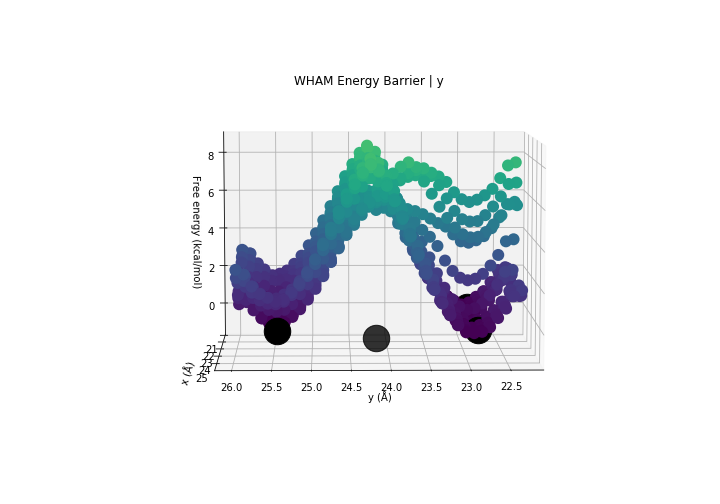

In [66]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')
max_energy = 12

for scanidx in range(len(scanlist)):
    data = SCAN_DATA[scanidx]
    scan_x_pos = [xpos[scanidx]] * len(data['coor'])
    F = np.array(data['free'])
    F[np.isinf(F)] = max_energy
    ax.scatter(data['coor'], scan_x_pos, data['free'], '-o', c=[cmap(i) for i in (F / max(F))], lw=2, s=100, alpha=1, zorder=len(scanlist) - scanidx)
    # ax.plot(data['coor'], scan_x_pos, data['free'], '-o', c=[cmap(i) for i in (F / max(F))], lw=2, markersize=6, alpha=1, zorder=len(scanlist) - scanidx)
    # ax.xlim(HIST[DRX])

# Plot surface atoms
surfatoms1 = [[21.582, 22.8912], [25.179, 22.8912], [21.582, 25.4346], [25.179, 25.4346]]
surfatoms2 = [23.3805, 24.1629]
for satom in surfatoms1:
    ax.scatter(satom[1], satom[0], 0, s=700, c='k')
ax.scatter(surfatoms2[1], surfatoms2[0], -1, s=700, c='k', alpha=0.8)

plt.title('WHAM Energy Barrier | %s' % DRX)
ax.set_xlabel('y (Å)')
ax.set_ylabel('x (Å)')
ax.set_zlabel('Free energy (kcal/mol)')
plt.show()

### Plot selected energy barrier and probability

In [54]:
def subplot(plot_fun, plot_args, nrow=1, width=3, height=3, dpi=200, save=None):
    n_plots = len(plot_args)
    ncol = np.ceil(n_plots / nrow)
    figsize = (ncol * width, nrow * height)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    fig.subplots_adjust(hspace=.5, wspace=.25)
    for idx, args in enumerate(plot_args, start=1):
        args['ax'] = fig.add_subplot(nrow, ncol, idx)
        plot_fun(**args)
    if save is not None:
        plt.savefig(save, dpi=dpi, transparent=True, bbox_inches='tight')

In [55]:
def wham_plot(x, y, ax, xlabel, ylabel, title, xlim):
    ax.plot(x, y, '-o', c='xkcd:crimson', lw=2, markersize=6)
    plt.xlim(xlim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [56]:
%matplotlib inline

In [57]:
data = SCAN_DATA[6]
plot_args = [dict(x=data['coor'], y=data['free'], xlabel='%s (Å)' % DRX, ylabel='Free energy (kcal/mol)', title='WHAM Energy Barrier | %s' % DRX, xlim=HIST[DRX]),
             dict(x=data['coor'], y=data['prob'], xlabel='%s (Å)' % DRX, ylabel='Probability', title='WHAM State Probability | %s' % DRX, xlim=HIST[DRX])]

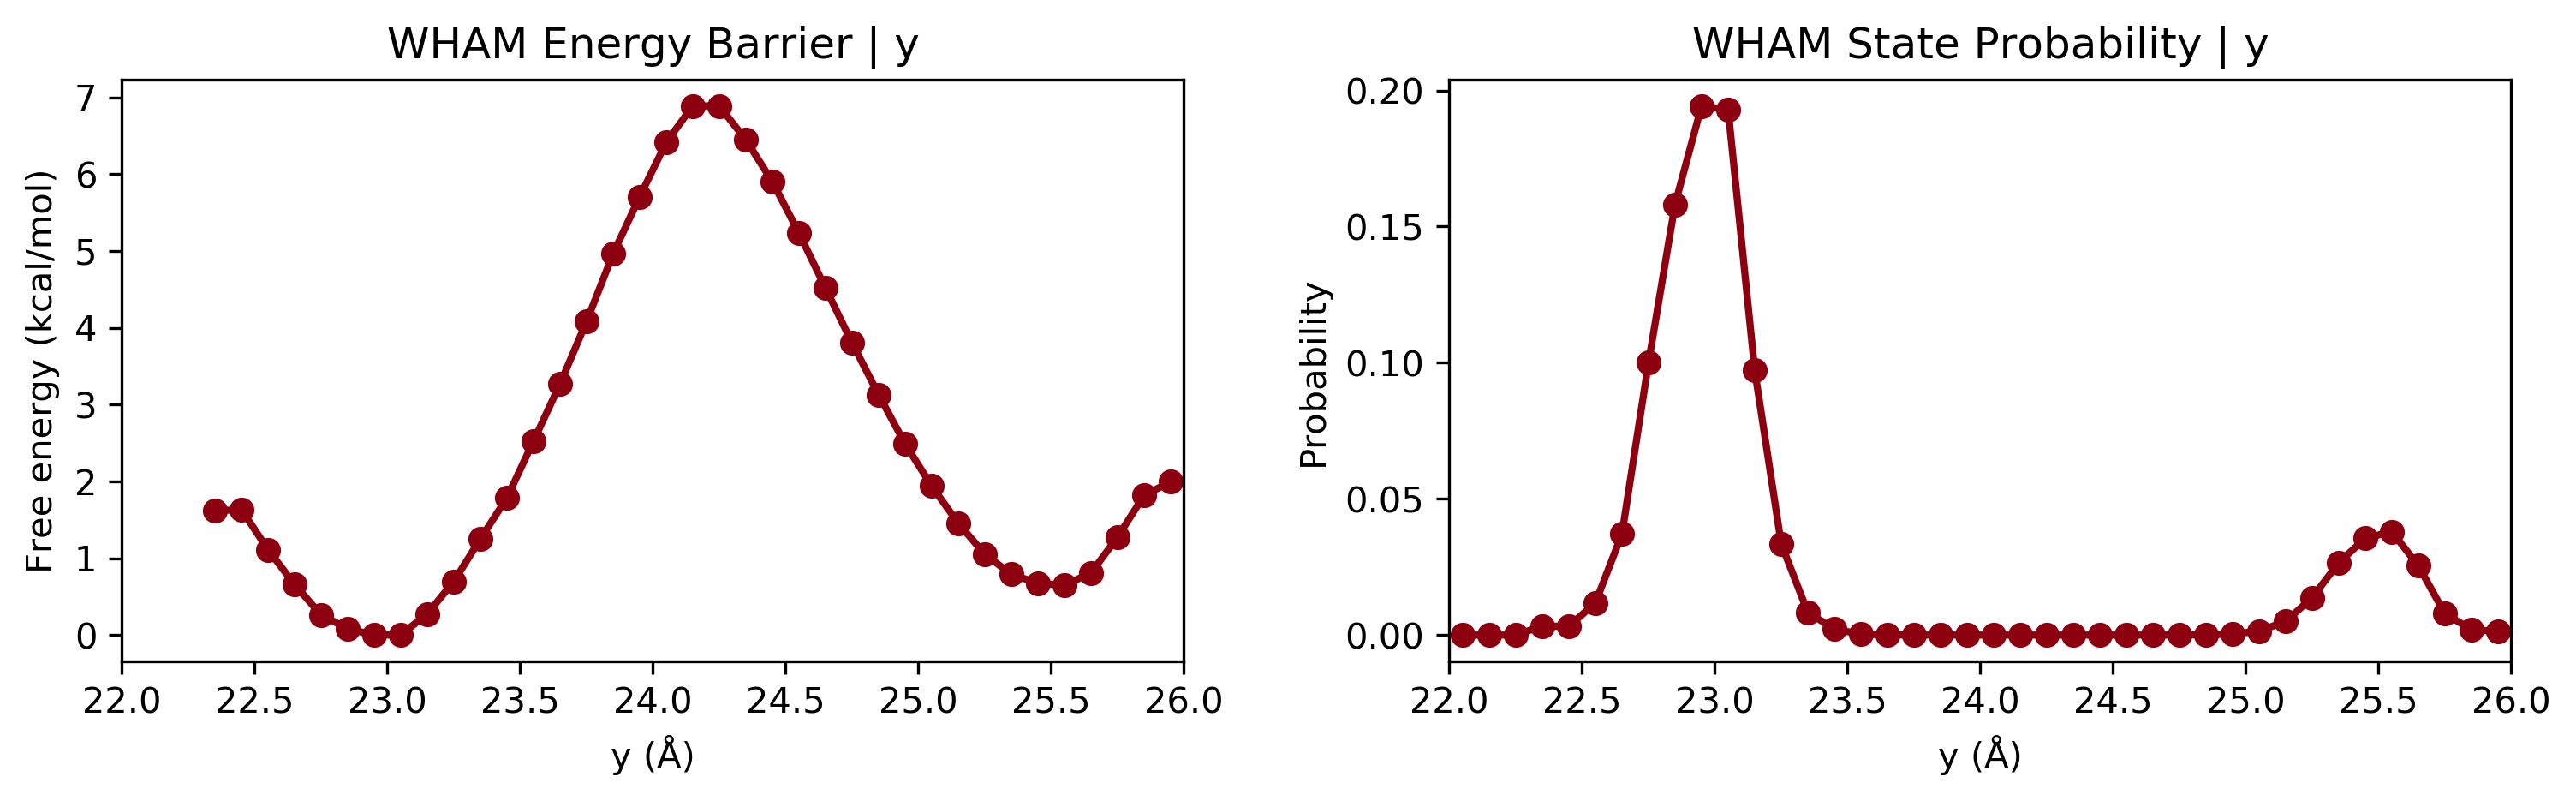

In [58]:
# pltfile = os.path.join('/home/kutay/Documents/git/Nanocar/docs/assets/img/dctst', '%s-wham.png' % SCAN)
# subplot(wham_plot, plot_args, width=6, save=pltfile, dpi=300)
subplot(wham_plot, plot_args, width=6, dpi=300)

Dump data to yaml file for plotting

In [59]:
import yaml

In [60]:
scan_yaml = {'x': [], 'y': [], 'z': []}
for scanidx in range(len(scanlist)):
    data = SCAN_DATA[scanidx]
    scan_x_pos = [xpos[scanidx]] * len(data['coor'])
    scan_yaml['x'] += scan_x_pos
    scan_yaml['y'] += data['coor']
    scan_yaml['z'] += data['free']

SURFDIR = os.path.join(SCANDIR, 'analysis', 'surface-plot')
with open(os.path.join(SURFDIR, '%s-data.yaml' % SCAN), 'w') as yf:
    yaml.dump(scan_yaml, yf)

### Calculate rate

$k_{A \rightarrow B} = \kappa {\sqrt{ \dfrac{1}{2 \pi M \beta}}} \dfrac{ e^{- \beta F(q^*)} } { \int e^{- \beta F(q)}dq }$

---------------------------------
- $k_B = 0.0019872041  kcal/mol$
- $kcal = 4.184 kJ$
- $J = \dfrac{kg m^2}{s^2}$
----------------------------------
${\sqrt{ \dfrac{1}{2 \pi M \beta}}} =  \sqrt{\dfrac{k_b T}{2 \pi M}}$

Substituting units (removing $2\pi$ and $k_B$):

$\sqrt{\dfrac{k_b T}{2 \pi M}} = \sqrt{\dfrac{\dfrac{kcal}{mol.K} K }{\dfrac{g}{mol} }} = \sqrt{\dfrac{kcal}{g}}$

Convert to Joule:

$\sqrt{\dfrac{kcal}{g}} = \sqrt{\dfrac{4.184 kJ}{g}} = \sqrt{\dfrac{4.184 \times 10^{-3} \dfrac{kg.m^2}{s^2}}{10^{-3} kg }} = \sqrt{\dfrac{4.184 \times 10^{6} m^2}{s^2}}$

Substitute constants and mass:

$\sqrt{\dfrac{0.0019872041 \times 4.184 \times 10^{6}}{2 \pi \times M}} \Big(\dfrac{m}{s}\Big) = 36.377 \sqrt{M} \Big(\dfrac{m}{s}\Big)$

----------------------------------

Finally (making sure $q$ is in meter units!):

$k_{A \rightarrow B} = \kappa \times 36.377 \sqrt{\dfrac{1}{M}} \dfrac{ e^{- \beta F(q^*)} } { \int e^{- \beta F(q)}dq }  \Big(\dfrac{1}{s}\Big)$


In [3]:
import numpy as np
from angstrom import Molecule

In [4]:
htbdc = Molecule(read='/home/kutay/Documents/git/Nanocar/molecules/surface-diffusion/opt/HtBDC.xyz')
M = htbdc.get_molecular_weight()       # g / mol

In [5]:
kappa = 1                              # Transmission coefficient
T = 200                                # K
kb = 0.0019872041                      # kcal / mol.K
beta = 1 / (kb * T)                    # mol / kcal
fq_tst = 13                            # kcal/mol
fq_star = np.exp(-beta * fq_tst)
dq = 2.765 * 1e-10                     # m
# fq_total = np.exp(-beta * 1)
fq_total = fq_star * 0.66
fq_integral = fq_total * dq            # kcal . m

In [6]:
k_AB1 = kappa * 36.377 * np.sqrt(1 / M) * fq_star / fq_integral
k_AB = kappa * np.sqrt(4.184e6 * kb * T / (2 * np.pi * M)) * fq_star / fq_integral
print('%.3e' % k_AB)

1.005e+11


### Integral calculated from WolframAlpha

$F(q) = e^{-4 ( \frac{nn}{2} - x)^2 + 2.57}$

$F(q^*) = 13 kcal/mol$

$nn = 2.765 Å$

https://www.wolframalpha.com/input/?i=integrate+exp(+-+2.516+*+exp(+-+4+*+(2.765+%2F+2+-+x)+%5E+2+%2B+2.57)+)+from+0+to+2.765

In [123]:
INTEGRAL = 0.774 * 1e-10  # m
kab_hand = np.sqrt(4.184e6 * 0.001987 * 200 / (2 * np.pi * 787.17)) * np.exp(-beta * 13) / (INTEGRAL)
print('%.3e 1/s' % kab_hand)

1.476e-03 1/s


In [124]:
ds_hand = 0.5 * kab_hand * ((6.8 * 2.765 * 1e-8) ** 2)
print('%.3e cm2/s' % ds_hand)

2.609e-17 cm2/s


### Calculate diffusion coefficient

$D_s = \dfrac{1}{2n} \times k_{A \rightarrow B} \times \lambda^2$

In [9]:
nn = 2.765
# nn = 0.0001
lamda = 6.8 * nn
D_s = 1 / 2 * k_AB * (lamda ** 2)  # A2 / s
D_s = D_s * 1e-16                  # cm2 /s 
print(D_s)

0.0017760205801


In [430]:
M

787.166039999999

Max: 13.01
area = 16299.9906064
area = 16299.9906064


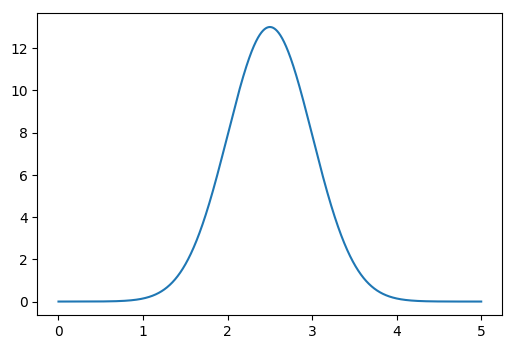

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import simps
from numpy import trapz

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(0, 5, 0.001)
y_axis = norm.pdf(x_axis, 2.5, .5) * 16.3
plt.plot(x_axis, y_axis)
print('Max: %.2f' % max(y_axis))
# Compute the area using the composite trapezoidal rule.
area = trapz(y_axis, dx=1)
print("area =", area)
# Compute the area using the composite Simpson's rule.
area = simps(y_axis, dx=1)
print("area =", area)

In [22]:
simps?

In [111]:
x2 = np.arange(0 , nn + 0.05, 0.05)
y2 = np.exp(- 4 * (nn / 2 - x2) ** 2 + 2.57)

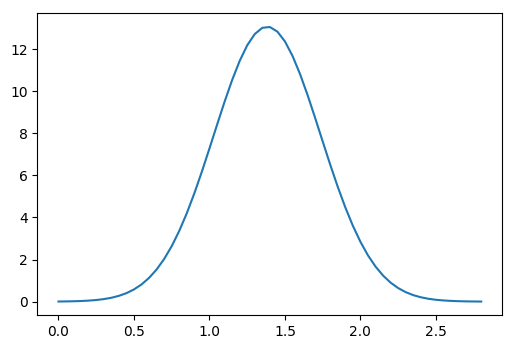

In [112]:
plt.plot(x2, y2)

In [108]:
max(y2)

13.049828605443965

In [115]:
beta

2.516097868356854